<a href="https://colab.research.google.com/github/renan-peres/mfin-portfolio-management/blob/main/03_benchmark_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Benchmark Selection with Regression Analysis
This model aims to select an ETF that best fits with the portfolio to be used as a benchmark. The methodology uses a regression analysis to identify the relationship between the ETF and the portfolio and check the ETF with the highest R² and lowest p-value will be selected as the benchmark. 

The model will use the following steps:
1. Select an ETF that invests in the same sectors as the portfolio holdings.
2. Use regression analysis to identify the relationship between the ETF and the portfolio.
3. Select the ETF with the highest R² and lowest p-value as the benchmark.
4. Use the selected ETF as a benchmark to evaluate the performance of the portfolio.

### Step 1: Import Libraries

In [7]:
# UDFs
from py.utils import load_and_filter_data, export_to_excel
from py.benchmark_regression import find_best_benchmark_and_run_regressions

# System libraries
import glob
import os
import sys
from io import StringIO
from typing import Dict, List

# Data manipulation libraries
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from pandas.tseries.offsets import BDay

# Data Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Excel libraries
from openpyxl import load_workbook
from openpyxl.styles import Alignment, Font
import ast

### Step 2: Define Parameters

#### Dates

In [8]:
# Define the date range
end_date = (datetime.today() - BDay(1)).to_pydatetime()  # Subtract 1 business day
start_date = end_date - timedelta(days=5*365)            # 5 years ago from the end date

# Convert datetime objects to Unix timestamps (seconds since Jan 1, 1970)
start_timestamp = int(start_date.timestamp())
end_timestamp = int(end_date.timestamp())

# Print the date range
days_difference = (end_date - start_date).days
print(f"Date Range: {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")
print(f"Time span: {days_difference} days ({days_difference/365:.2f} years)")

Date Range: 2020-05-31 to 2025-05-30
Time span: 1825 days (5.00 years)


#### Risk-free rate (T-bill, %)

In [9]:
# Load and process data
daily_risk_free_df = load_and_filter_data('data/daily_treasury_rates.csv', ['^IRX'], start_date, end_date)
# risk_free_rate = .0433 
risk_free_rate = daily_risk_free_df.iloc[-1, 0] / 100
risk_free_rate_monthly = risk_free_rate / 12

# Display result
print("Risk-Free Rate:", risk_free_rate, "-- 13 WEEK TREASURY BILL (^IRX)")
daily_risk_free_df.head()

Found 1 of 1 tickers in data/daily_treasury_rates.csv
Missing tickers: []
Risk-Free Rate: 0.042300000000000004 -- 13 WEEK TREASURY BILL (^IRX)


,^IRX
Date,
2020-06-01,0.128
2020-06-02,0.145
2020-06-03,0.148
2020-06-04,0.140
2020-06-05,0.145


#### Report File

In [10]:
# Get the most recent portfolio file
portfolio_files = glob.glob('portfolios/portfolio-*.xlsx')
if portfolio_files:
    # Sort files by modification time (most recent first)
    output_file = max(portfolio_files, key=os.path.getmtime)
    print(f"Using most recent portfolio file: {output_file}")
else:
    # Fallback to current date if no files found
    output_file = f'portfolios/portfolio-{datetime.date(end_date)}.xlsx'
    print(f"No portfolio files found. Using: {output_file}")

Using most recent portfolio file: portfolios/portfolio-2025-05-30.xlsx


### Step 3: Read ETF Data

In [11]:
# Load Data
sectors_df = pd.read_csv("data/fundamentals_benchmark.csv") 
sectors_df = sectors_df[["Ticker", "Name", "Sector Weightings"]]
sectors_df = sectors_df.rename(columns={"Name": "Name", "Ticker": "Symbol", "Sector Weightings": "Sectors"})

# Convert string representations of dictionaries to actual dictionaries
sectors_df['Sectors'] = sectors_df['Sectors'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) and x.strip() else {})

# Display
sectors_df.head()

,Symbol,Name,Sectors
0,AADR,AdvisorShares Dorsey Wright ADR ETF,"{'realestate': 0.0, 'consumer_cyclical': 0.118..."
1,ABFL,Abacus FCF Leaders ETF,"{'realestate': 0.0, 'consumer_cyclical': 0.118..."
2,ACWI,iShares MSCI ACWI ETF,"{'realestate': 0.0216, 'consumer_cyclical': 0...."
3,ADME,Aptus Drawdown Managed Equity ETF,"{'realestate': 0.0222, 'consumer_cyclical': 0...."
4,AGNG,Global X Aging Population ETF,"{'realestate': 0.0791, 'consumer_cyclical': 0...."


### Step 4: Read Portfolio Data (Excel)

In [12]:
portfolio_df = pd.read_excel(output_file, sheet_name="long_term")   
portfolio_tickers = portfolio_df["Ticker"].tolist()
# portfolio_df["Weight"] = portfolio_df['Weight'].str.rstrip('%').astype(float) / 100
portfolio_df["P/E (trailing)"] = pd.to_numeric(portfolio_df["P/E (trailing)"], errors="coerce")

print(portfolio_tickers)
display(portfolio_df)

['PH', 'TMUS', 'MMC', 'MS', 'SO']


,Ticker,Date,Name,Sector,Industry,Country,Website,Market Cap,Enterprise Value,Float Shares,...,52W High,52W Low,50 Day Avg,200 Day Avg,Short Ratio,Short % of Float,Weight,Expected Return,Standard Deviation,Sharpe Ratio
0,PH,2025-06-02,Parker-Hannifin Corporation,Industrials,Specialty Industrial Machinery,United States,https://investors.parker.com,84934041600,93907066880,127309059,...,718.44,488.45,616.15,638.43,2.02,0.01,0.255903,0.255491,0.301570,0.847203
1,TMUS,2025-06-02,"T-Mobile US, Inc.",Communication Services,Telecom Services,United States,https://www.t-mobile.com,275005997056,384693796864,452736028,...,276.49,171.18,251.20,232.97,3.11,0.03,0.238439,0.165449,0.242122,0.683330
2,MMC,2025-06-02,"Marsh & McLennan Companies, Inc.",Financial Services,Insurance Brokers,United States,https://www.marshmclennan.com,115130826752,136148770816,491821141,...,248.00,205.17,229.54,225.30,2.62,0.01,0.234241,0.164748,0.193265,0.852447
3,MS,2025-06-02,Morgan Stanley,Financial Services,Capital Markets,United States,https://www.morganstanley.com,205401079808,116566982656,1222507242,...,142.03,90.94,118.37,119.95,2.69,0.01,0.161366,0.234275,0.300345,0.780019
4,SO,2025-06-02,The Southern Company,Utilities,Utilities - Regulated Electric,United States,https://www.southerncompany.com,99017097216,170091954176,1095713937,...,94.45,76.96,89.88,87.92,5.08,0.02,0.110051,0.113617,0.194803,0.583240


### Step 5: Benchmark Sector Screening

#### Filter Sectors by Portfolio

In [13]:
# Sort portfolio sectors by weight (descending)
portfolio_sector_weights = (
    portfolio_df.groupby('Sector')['Weight'].sum()
    .sort_values(ascending=False)
)
ordered_portfolio_sectors = [sector.strip() for sector in portfolio_sector_weights.index]
normalized_ordered_portfolio_sectors = [sector.strip().lower().replace(" ", "_") for sector in ordered_portfolio_sectors]

# Filter directly with lambda expression instead of using a separate function
filtered_sectors_df = sectors_df[
    sectors_df['Sectors'].apply(
        lambda sector_dict: isinstance(sector_dict, dict) and all(
            sector in sector_dict and sector_dict[sector] > 0 
            for sector in normalized_ordered_portfolio_sectors
        )
    )
].reset_index(drop=True)

# Display Outputs
tickers = filtered_sectors_df["Symbol"].tolist()
print("Number of benchmarks left:", len(tickers))
display(filtered_sectors_df.head())

Number of benchmarks left: 289


,Symbol,Name,Sectors
0,AADR,AdvisorShares Dorsey Wright ADR ETF,"{'realestate': 0.0, 'consumer_cyclical': 0.118..."
1,ACWI,iShares MSCI ACWI ETF,"{'realestate': 0.0216, 'consumer_cyclical': 0...."
2,ADME,Aptus Drawdown Managed Equity ETF,"{'realestate': 0.0222, 'consumer_cyclical': 0...."
3,AOA,iShares Core 80/20 Aggressive Allocation ETF,"{'realestate': 0.0279, 'consumer_cyclical': 0...."
4,AOK,iShares Core 30/70 Conservative Allocation ETF,"{'realestate': 0.027999999, 'consumer_cyclical..."


#### Import ETF Fundamental Data

In [14]:
# fundamentals_df = fetch_fundamentals(tickers) # Download fundamentals data for the tickers
fundamentals_df = pd.read_csv("data/fundamentals_benchmark.csv",index_col="Ticker").query("Ticker in @tickers") # Import the fundamentals data from a CSV file

# Set the index name
fundamentals_df.index.name = "Symbol"

# Move the index into a column
fundamentals_df = fundamentals_df.reset_index()

# Perform the merge
merged_df = pd.merge(filtered_sectors_df, fundamentals_df, on='Symbol', how='inner').dropna(how='all', axis=1)

# Display the merged DataFrame
display(merged_df.head())

,Symbol,Name_x,Sectors,Date,Name_y,Sector,Industry,Country,Website,Market Cap,...,Dividend Rate (%),5Y Avg Dividend Yield (%),Payout Ratio (%),Price,Analyst Rating,52W High,52W Low,50 Day Avg,200 Day Avg,Sector Weightings
0,AADR,AdvisorShares Dorsey Wright ADR ETF,"{'realestate': 0.0, 'consumer_cyclical': 0.118...",2025-06-02,AdvisorShares Dorsey Wright ADR ETF,Unknown,Unknown,Unknown,Unknown,0.0,...,0.0,0.0,0.0,77.58,Unknown,81.17,54.57,74.66,70.09,"{""realestate"": 0.0, ""consumer_cyclical"": 0.118..."
1,ACWI,iShares MSCI ACWI ETF,"{'realestate': 0.0216, 'consumer_cyclical': 0....",2025-06-02,iShares MSCI ACWI ETF,Unknown,Unknown,Unknown,Unknown,0.0,...,0.0,0.0,0.0,123.65,Unknown,124.54,101.25,117.25,118.68,"{""realestate"": 0.0216, ""consumer_cyclical"": 0...."
2,ADME,Aptus Drawdown Managed Equity ETF,"{'realestate': 0.0222, 'consumer_cyclical': 0....",2025-05-02,Aptus Drawdown Managed Equity ETF,Unknown,Unknown,Unknown,Unknown,0.0,...,0.0,0.0,0.0,44.46,Unknown,48.56,39.85,44.34,45.90,"{""realestate"": 0.0222, ""consumer_cyclical"": 0...."
3,AOA,iShares Core 80/20 Aggressive Allocation ETF,"{'realestate': 0.0279, 'consumer_cyclical': 0....",2025-05-02,iShares Core 80/20 Aggressive Allocation ETF,Unknown,Unknown,Unknown,Unknown,0.0,...,0.0,0.0,0.0,77.74,Unknown,80.20,68.45,76.13,77.15,"{""realestate"": 0.0279, ""consumer_cyclical"": 0...."
4,AOK,iShares Core 30/70 Conservative Allocation ETF,"{'realestate': 0.027999999, 'consumer_cyclical...",2025-06-02,iShares Core 30/70 Conservative Allocation ETF,Unknown,Unknown,Unknown,Unknown,0.0,...,0.0,0.0,0.0,38.21,Unknown,38.77,35.79,37.53,37.84,"{""realestate"": 0.027999999, ""consumer_cyclical..."


#### Filter for the P/E (Trailling) Similar to Portfolio Weighted Average P/E

In [15]:
# Step 1: Calculate the weighted average of P/E (trailing) in portfolio_df
weighted_average_pe = (portfolio_df["Weight"] * portfolio_df["P/E (trailing)"]).sum()

# Step 2: Calculate the 20% threshold range
lower_bound = weighted_average_pe * 0.8  # 20% below the weighted average
upper_bound = weighted_average_pe * 1.2  # 2% above the weighted average

# Step 3: Filter merged_df based on the P/E (trailing) column
filtered_merged_df = merged_df[
    (merged_df["P/E (trailing)"] >= lower_bound) & 
    (merged_df["P/E (trailing)"] <= upper_bound)
]

filtered_sectors_df = filtered_merged_df.copy().dropna(how='all')
tickers = filtered_sectors_df["Symbol"].tolist()

# Display the filtered DataFrame
print("Portfolio Weighted Average P/E (trailing):", weighted_average_pe)
print("Lower Bound:", lower_bound)
print("Upper Bound:", upper_bound)
print("Number of benchmarks after filtering by P/E (trailing):", len(filtered_merged_df))
display(filtered_sectors_df.head())

Portfolio Weighted Average P/E (trailing): 23.693006474140773
Lower Bound: 18.95440517931262
Upper Bound: 28.431607768968927
Number of benchmarks after filtering by P/E (trailing): 118


,Symbol,Name_x,Sectors,Date,Name_y,Sector,Industry,Country,Website,Market Cap,...,Dividend Rate (%),5Y Avg Dividend Yield (%),Payout Ratio (%),Price,Analyst Rating,52W High,52W Low,50 Day Avg,200 Day Avg,Sector Weightings
1,ACWI,iShares MSCI ACWI ETF,"{'realestate': 0.0216, 'consumer_cyclical': 0....",2025-06-02,iShares MSCI ACWI ETF,Unknown,Unknown,Unknown,Unknown,0.0,...,0.0,0.0,0.0,123.65,Unknown,124.54,101.25,117.25,118.68,"{""realestate"": 0.0216, ""consumer_cyclical"": 0...."
2,ADME,Aptus Drawdown Managed Equity ETF,"{'realestate': 0.0222, 'consumer_cyclical': 0....",2025-05-02,Aptus Drawdown Managed Equity ETF,Unknown,Unknown,Unknown,Unknown,0.0,...,0.0,0.0,0.0,44.46,Unknown,48.56,39.85,44.34,45.90,"{""realestate"": 0.0222, ""consumer_cyclical"": 0...."
3,AOA,iShares Core 80/20 Aggressive Allocation ETF,"{'realestate': 0.0279, 'consumer_cyclical': 0....",2025-05-02,iShares Core 80/20 Aggressive Allocation ETF,Unknown,Unknown,Unknown,Unknown,0.0,...,0.0,0.0,0.0,77.74,Unknown,80.20,68.45,76.13,77.15,"{""realestate"": 0.0279, ""consumer_cyclical"": 0...."
4,AOK,iShares Core 30/70 Conservative Allocation ETF,"{'realestate': 0.027999999, 'consumer_cyclical...",2025-06-02,iShares Core 30/70 Conservative Allocation ETF,Unknown,Unknown,Unknown,Unknown,0.0,...,0.0,0.0,0.0,38.21,Unknown,38.77,35.79,37.53,37.84,"{""realestate"": 0.027999999, ""consumer_cyclical..."
5,AOM,iShares Core 40/60 Moderate Allocation ETF,"{'realestate': 0.027999999, 'consumer_cyclical...",2025-06-02,iShares Core 40/60 Moderate Allocation ETF,Unknown,Unknown,Unknown,Unknown,0.0,...,0.0,0.0,0.0,44.78,Unknown,45.31,41.20,43.73,44.12,"{""realestate"": 0.027999999, ""consumer_cyclical..."


### Step 6: Import Quotes

#### Benchmark Tickers

In [16]:
# Load and filter historical benchmark price data
benchmark_prices_daily_df = load_and_filter_data('data/daily_benchmark_quotes.csv', tickers, start_date, end_date)
benchmark_prices_monthly_df = load_and_filter_data('data/monthly_benchmark_quotes.csv', tickers, start_date, end_date)

# Display the first few rows
benchmark_prices_monthly_df.head()

Found 109 of 118 tickers in data/daily_benchmark_quotes.csv
Missing tickers: ['AOA', 'CZA', 'IJK', 'ILCB', 'IVOG', 'IYY', 'MDYG', 'UPGD', 'VIS']
Found 109 of 118 tickers in data/monthly_benchmark_quotes.csv
Missing tickers: ['AOA', 'CZA', 'IJK', 'ILCB', 'IVOG', 'IYY', 'MDYG', 'UPGD', 'VIS']


,ACWI,ADME,AOK,AOM,AOR,BAPR,BBUS,BJAN,BJUL,BOCT,...,VT,VUSE,VV,WOMN,WTMF,XLG,XRLV,XSMO,YLDE,YYY
Date,,,,,,,,,,,,,,,,,,,,,
2020-06-01,68.12,31.24,32.27,35.37,41.53,27.603001,52.47,28.3620,26.9900,25.889999,...,67.88,25.91,133.47,18.59,26.94,22.62,32.49,34.74,27.88,8.45
2020-07-01,71.77,32.74,33.06,36.44,42.99,28.221600,55.55,29.5439,27.9200,26.838900,...,71.48,26.96,141.45,19.82,27.31,24.04,34.72,37.94,29.40,8.77
2020-08-01,76.10,34.35,33.54,37.19,44.48,28.774900,59.81,30.6800,28.8268,27.805000,...,75.77,28.39,152.24,22.21,27.18,26.36,36.08,39.01,30.90,9.03
2020-09-01,73.85,32.83,33.14,36.65,43.65,28.567700,57.46,30.1600,28.3400,27.887500,...,73.55,27.22,146.61,21.47,26.95,24.99,35.29,38.57,30.42,8.88
2020-10-01,72.21,32.25,32.89,36.23,42.95,28.323500,56.00,29.8300,27.8300,27.240000,...,72.04,27.13,142.95,20.92,26.79,24.10,34.02,38.28,29.50,8.73


#### Portfolio Tickers

In [17]:
# Load and filter historical benchmark price data
stock_prices_monthly_df = load_and_filter_data('data/monthly_stock_quotes.csv', portfolio_tickers, start_date, end_date)

# Display the first few rows
stock_prices_monthly_df.head()

Found 5 of 5 tickers in data/monthly_stock_quotes.csv
Missing tickers: []


,MMC,MS,PH,SO,TMUS
Date,,,,,
2020-06-01,100.13,38.70,170.80,43.03,101.85
2020-07-01,109.18,39.44,166.75,45.32,105.01
2020-08-01,107.59,42.16,192.80,43.81,114.10
2020-09-01,107.40,39.01,189.37,45.52,111.83
2020-10-01,97.27,39.14,195.00,48.24,107.15


### Step 7: Prepare Data (Drop Invalid Tickers)

#### Daily Quotes

In [18]:
# Identify columns with null values in first or last 50 rows
first_50_nulls = benchmark_prices_daily_df.head(50).isnull().any()
last_50_nulls = benchmark_prices_daily_df.tail(50).isnull().any()

# Columns to drop are those with nulls in first 50 OR last 50 rows
columns_to_drop = first_50_nulls | last_50_nulls
bad_columns = columns_to_drop[columns_to_drop].index.tolist()

print(f"Dropping {len(bad_columns)} columns with missing values in first/last 50 records: {bad_columns}")

# Drop those columns
benchmark_prices_daily_df = benchmark_prices_daily_df.loc[:, ~columns_to_drop]

# Display the first few rows of the cleaned dataframe
benchmark_prices_daily_df.head()

Dropping 0 columns with missing values in first/last 50 records: []


,ACWI,ADME,AOK,AOM,AOR,BAPR,BBUS,BJAN,BJUL,BOCT,...,VT,VUSE,VV,WOMN,WTMF,XLG,XRLV,XSMO,YLDE,YYY
Date,,,,,,,,,,,,,,,,,,,,,
2020-06-01,67.02,31.07,31.83,34.96,40.98,27.4465,51.65,28.139999,26.840000,25.5700,...,66.71,25.83,131.35,18.29,26.86,21.92,32.52,33.75,27.79,8.48
2020-06-02,67.75,31.06,32.02,35.18,41.24,27.5208,52.05,28.195000,26.959999,25.6900,...,67.45,26.21,132.45,18.44,26.91,22.08,32.76,34.04,27.87,8.57
2020-06-03,68.86,31.18,32.19,35.43,41.70,27.7090,52.81,28.503700,27.309999,25.9500,...,68.65,26.83,134.30,18.66,26.70,22.26,33.21,35.12,28.51,8.66
2020-06-04,68.49,30.79,32.10,35.25,41.51,27.6788,52.52,28.476500,27.136400,25.8864,...,68.32,26.97,133.73,18.56,26.67,22.15,33.13,35.21,28.43,8.63
2020-06-05,70.05,31.31,32.38,35.64,42.17,28.0298,53.92,29.190000,27.719999,26.2656,...,69.96,27.93,137.14,18.94,26.52,22.70,33.82,36.48,29.12,8.72


#### Monthly Quotes

In [19]:
benchmark_prices_monthly_df = (benchmark_prices_daily_df.set_index(pd.to_datetime(benchmark_prices_daily_df.pop('Date')))
      if 'Date' in benchmark_prices_daily_df.columns else benchmark_prices_daily_df.copy())
benchmark_prices_monthly_df.index = pd.to_datetime(benchmark_prices_monthly_df.index)              
benchmark_prices_monthly_df = (benchmark_prices_monthly_df.resample('MS').last()
   .reset_index()
   .rename(columns={'index': 'Date'}))

benchmark_prices_monthly_df.set_index('Date', inplace=True)
display(benchmark_prices_monthly_df.head())

,ACWI,ADME,AOK,AOM,AOR,BAPR,BBUS,BJAN,BJUL,BOCT,...,VT,VUSE,VV,WOMN,WTMF,XLG,XRLV,XSMO,YLDE,YYY
Date,,,,,,,,,,,,,,,,,,,,,
2020-06-01,68.12,31.24,32.27,35.37,41.53,27.603001,52.47,28.3620,26.9900,25.889999,...,67.88,25.91,133.47,18.59,26.94,22.62,32.49,34.74,27.88,8.45
2020-07-01,71.77,32.74,33.06,36.44,42.99,28.221600,55.55,29.5439,27.9200,26.838900,...,71.48,26.96,141.45,19.82,27.31,24.04,34.72,37.94,29.40,8.77
2020-08-01,76.10,34.35,33.54,37.19,44.48,28.774900,59.81,30.6800,28.8268,27.805000,...,75.77,28.39,152.24,22.21,27.18,26.36,36.08,39.01,30.90,9.03
2020-09-01,73.85,32.83,33.14,36.65,43.65,28.567700,57.46,30.1600,28.3400,27.887500,...,73.55,27.22,146.61,21.47,26.95,24.99,35.29,38.57,30.42,8.88
2020-10-01,72.21,32.25,32.89,36.23,42.95,28.323500,56.00,29.8300,27.8300,27.240000,...,72.04,27.13,142.95,20.92,26.79,24.10,34.02,38.28,29.50,8.73


### Step 8: Calculate Returns (Lognormal)

#### Benchmark

In [20]:
benchmark_log_returns_df = np.log(benchmark_prices_monthly_df / benchmark_prices_monthly_df.shift(1))
benchmark_log_returns_df = benchmark_log_returns_df.dropna().sort_index(axis=0, ascending=True).sort_index(axis=1, ascending=True)
benchmark_log_returns_df.head()

,ACWI,ADME,AOK,AOM,AOR,BAPR,BBUS,BJAN,BJUL,BOCT,...,VT,VUSE,VV,WOMN,WTMF,XLG,XRLV,XSMO,YLDE,YYY
Date,,,,,,,,,,,,,,,,,,,,,
2020-07-01,0.052196,0.046898,0.024186,0.029803,0.034551,0.022163,0.057042,0.040827,0.033877,0.035996,...,0.051676,0.039725,0.058070,0.064068,0.013641,0.060885,0.066384,0.088114,0.053085,0.037170
2020-08-01,0.058582,0.048004,0.014415,0.020373,0.034072,0.019416,0.073889,0.037734,0.031962,0.035364,...,0.058285,0.051683,0.073512,0.113851,-0.004772,0.092129,0.038423,0.027812,0.049762,0.029216
2020-09-01,-0.030012,-0.045259,-0.011998,-0.014626,-0.018836,-0.007227,-0.040084,-0.017094,-0.017031,0.002963,...,-0.029737,-0.042085,-0.037682,-0.033886,-0.008498,-0.053372,-0.022139,-0.011343,-0.015656,-0.016751
2020-10-01,-0.022457,-0.017825,-0.007572,-0.011526,-0.016167,-0.008585,-0.025737,-0.011002,-0.018160,-0.023492,...,-0.020744,-0.003312,-0.025281,-0.025951,-0.005955,-0.036264,-0.036651,-0.007547,-0.030710,-0.017036
2020-11-01,0.111160,0.054606,0.041685,0.050327,0.072510,0.040003,0.110295,0.066778,0.063685,0.075968,...,0.116610,0.147441,0.105402,0.118420,0.027611,0.088117,0.085050,0.124379,0.098387,0.101228


#### Stocks

In [21]:
stock_log_returns_df = np.log(stock_prices_monthly_df / stock_prices_monthly_df.shift(1))
stock_log_returns_df = stock_log_returns_df.dropna().sort_index(axis=0, ascending=True).sort_index(axis=1, ascending=True)
stock_log_returns_df.head()

,MMC,MS,PH,SO,TMUS
Date,,,,,
2020-07-01,0.086529,0.018941,-0.023998,0.051851,0.030554
2020-08-01,-0.014670,0.066691,0.145158,-0.033886,0.083020
2020-09-01,-0.001768,-0.077654,-0.017951,0.038290,-0.020095
2020-10-01,-0.099070,0.003327,0.029297,0.058037,-0.042750
2020-11-01,0.102601,0.250065,0.253011,0.050920,0.193305


### Step 9: Calculate Excess Return (Expected Return - Risk-free Rate)

#### Benchmark

In [22]:
benchmark_excess_returns_df = benchmark_log_returns_df - risk_free_rate_monthly
benchmark_excess_returns_df.head()

,ACWI,ADME,AOK,AOM,AOR,BAPR,BBUS,BJAN,BJUL,BOCT,...,VT,VUSE,VV,WOMN,WTMF,XLG,XRLV,XSMO,YLDE,YYY
Date,,,,,,,,,,,,,,,,,,,,,
2020-07-01,0.048671,0.043373,0.020661,0.026278,0.031026,0.018638,0.053517,0.037302,0.030352,0.032471,...,0.048151,0.036200,0.054545,0.060543,0.010116,0.057360,0.062859,0.084589,0.049560,0.033645
2020-08-01,0.055057,0.044479,0.010890,0.016848,0.030547,0.015891,0.070364,0.034209,0.028437,0.031839,...,0.054760,0.048158,0.069987,0.110326,-0.008297,0.088604,0.034898,0.024287,0.046237,0.025691
2020-09-01,-0.033537,-0.048784,-0.015523,-0.018151,-0.022361,-0.010752,-0.043609,-0.020619,-0.020556,-0.000562,...,-0.033262,-0.045610,-0.041207,-0.037411,-0.012023,-0.056897,-0.025664,-0.014868,-0.019181,-0.020276
2020-10-01,-0.025982,-0.021350,-0.011097,-0.015051,-0.019692,-0.012110,-0.029262,-0.014527,-0.021685,-0.027017,...,-0.024269,-0.006837,-0.028806,-0.029476,-0.009480,-0.039789,-0.040176,-0.011072,-0.034235,-0.020561
2020-11-01,0.107635,0.051081,0.038160,0.046802,0.068985,0.036478,0.106770,0.063253,0.060160,0.072443,...,0.113085,0.143916,0.101877,0.114895,0.024086,0.084592,0.081525,0.120854,0.094862,0.097703


#### Stocks

In [23]:
stock_excess_returns_df = stock_log_returns_df - risk_free_rate_monthly
stock_excess_returns_df.head()

,MMC,MS,PH,SO,TMUS
Date,,,,,
2020-07-01,0.083004,0.015416,-0.027523,0.048326,0.027029
2020-08-01,-0.018195,0.063166,0.141633,-0.037411,0.079495
2020-09-01,-0.005293,-0.081179,-0.021476,0.034765,-0.023620
2020-10-01,-0.102595,-0.000198,0.025772,0.054512,-0.046275
2020-11-01,0.099076,0.246540,0.249486,0.047395,0.189780


### Step 10: Find the Best Benchmark (By Regression Coefficients)

In [24]:
# Call the function with your data
best_benchmark, benchmark_stats_df, best_benchmarks_df = find_best_benchmark_and_run_regressions(
    benchmark_excess_returns_df, 
    stock_excess_returns_df
)

# Display the results
print(f"Best benchmark: {best_benchmark}")
display(best_benchmarks_df)

Best benchmark: FCEF


,Equity,Benchmark,intercept (alpha),slope (beta),correlation,r_squared,p_value_slope,p_value_intercept
0,MMC,FCEF,0.008131,0.975588,NaN,0.540465,4.912066e-07,0.272577
1,MS,FCEF,0.020216,1.394058,NaN,0.532911,6.469240e-07,0.064561
2,PH,FCEF,0.006751,1.313499,NaN,0.583186,9.485635e-08,0.458276
3,SO,FCEF,0.007087,0.609145,NaN,0.268994,1.413082e-03,0.389885
4,TMUS,FCEF,0.008286,0.768369,NaN,0.239437,2.852816e-03,0.460384


In [25]:
# Display the benchmark statistics
display(benchmark_stats_df.sort_values(by="score", ascending=False).head(10))

,benchmark,avg_slope,slope_std,avg_p_value_intercept,avg_p_value_slope,avg_r_squared,beta_quality,score
24,FCEF,1.012132,0.303263,0.329137,0.000853,0.432999,0.987868,0.771636
32,IDHQ,0.855583,0.223872,0.178697,0.001955,0.357300,0.855583,0.769862
97,YYY,1.152200,0.385763,0.161236,0.001522,0.411738,0.847800,0.763681
65,QDF,1.026815,0.311464,0.355250,0.000978,0.436285,0.973185,0.763150
0,ACWI,1.000309,0.362446,0.332552,0.002694,0.416593,0.999691,0.763002
6,CRBN,0.986149,0.365435,0.324712,0.002874,0.418844,0.986149,0.761955
39,IQLT,0.896850,0.255550,0.248536,0.002209,0.365621,0.896850,0.761638
89,VT,0.997821,0.363219,0.341174,0.002526,0.419897,0.997821,0.761515
7,DEUS,1.029355,0.278311,0.448461,0.000407,0.467257,0.970645,0.754263
64,QDEF,1.089119,0.265834,0.367575,0.000533,0.438115,0.910881,0.754176


### Step 11: Display Bechmark Sector Exposure        

In [26]:
best_benchmark = filtered_sectors_df[filtered_sectors_df["Symbol"] == best_benchmarks_df['Benchmark'].unique()[0]]
best_benchmark = best_benchmark[["Symbol", "Name_x", "Sectors"]] 
best_benchmark = best_benchmark.rename(columns={"Name_x": "Name"})
display(best_benchmark)

,Symbol,Name,Sectors
76,FCEF,First Trust Income Opportunity ETF,"{'realestate': 0.060100004, 'consumer_cyclical..."


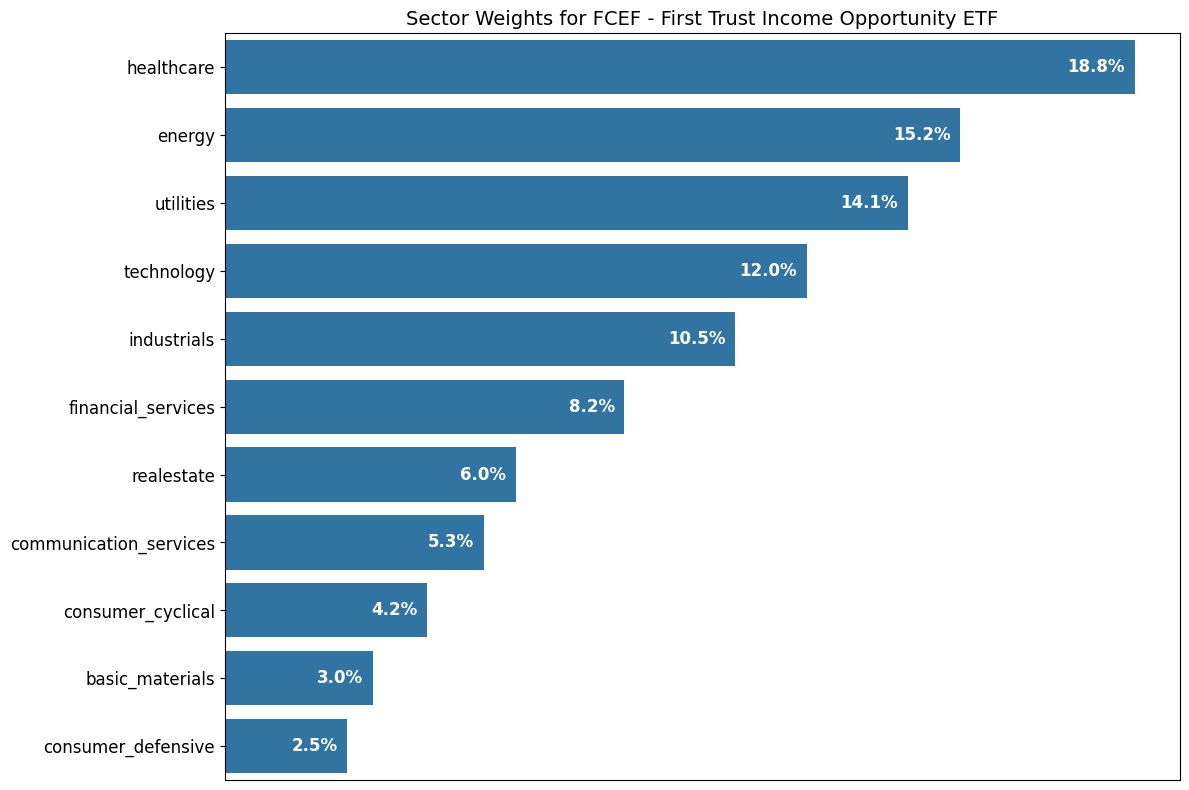

In [27]:
# Get the sector dictionary from the first row
sector_dict = best_benchmark["Sectors"].iloc[0]

# Create a pandas Series from the dictionary for easier plotting
sectors_series = pd.Series(sector_dict)

# Sort by weight for better visualization
sectors_series = sectors_series.sort_values(ascending=False)

# Create the plot - swap x and y for horizontal bars
plt.figure(figsize=(12, 8))
ax = sns.barplot(x=sectors_series.values, y=sectors_series.index)

# Titles and labels
plt.title(f'Sector Weights for {best_benchmark["Symbol"].iloc[0]} - {best_benchmark["Name"].iloc[0]}', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks([])
# plt.xlabel('Weight (%)', fontsize=12)
# plt.ylabel('Sector', fontsize=12)
plt.xlabel(None)
plt.ylabel(None)

# Add percentage labels at the center end of each bar
for i, v in enumerate(sectors_series.values):
    ax.text(v - 0.002, i, f'{v:.1%}', va='center', ha='right', fontsize=12, color='white', fontweight='bold')

# Show plot
plt.tight_layout()
plt.show()

### Step 12: Export Data to Excel

In [28]:
# Set Index
first_column = best_benchmarks_df.columns[0] # Get the name of the first column
best_benchmarks_df.set_index(first_column, drop=True, inplace=True)
best_benchmark = best_benchmarks_df['Benchmark'].unique()[0]

# Display the best benchmark DataFrame
print(best_benchmark)
best_benchmarks_df

FCEF


,Benchmark,intercept (alpha),slope (beta),correlation,r_squared,p_value_slope,p_value_intercept
Equity,,,,,,,
MMC,FCEF,0.008131,0.975588,NaN,0.540465,4.912066e-07,0.272577
MS,FCEF,0.020216,1.394058,NaN,0.532911,6.469240e-07,0.064561
PH,FCEF,0.006751,1.313499,NaN,0.583186,9.485635e-08,0.458276
SO,FCEF,0.007087,0.609145,NaN,0.268994,1.413082e-03,0.389885
TMUS,FCEF,0.008286,0.768369,NaN,0.239437,2.852816e-03,0.460384


In [29]:
export_to_excel(output_file, {
    'benchmark': best_benchmarks_df,
    'daily_quotes': benchmark_prices_daily_df[[best_benchmark]],  
    'monthly_quotes': benchmark_prices_monthly_df[[best_benchmark]]   
})

Updated sheet 'benchmark'
Successfully merged data into 'daily_quotes' sheet
Successfully merged data into 'monthly_quotes' sheet
Successfully exported all data to portfolios/portfolio-2025-05-30.xlsx
